<a href="https://colab.research.google.com/github/nirmalpate/A-B-Testing-For-Pricing/blob/main/Bolt_A/BTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- INSTALL LIBRARIES (If using Colab) ---
!pip install faker xgboost pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import faker
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize
fake = faker.Faker()
np.random.seed(42) # Consistent results

# --- CONFIGURATION ---
NUM_RIDERS = 5000
NUM_DRIVERS = 400
NUM_RIDES = 40000
START_DATE = datetime(2023, 6, 1)
END_DATE = datetime(2024, 6, 1)

print("--- 1. GENERATING REALISTIC RIDER DATA ---")

# We use Exponential Distribution for user lifespan to simulate "Activation Drop-off"
# Most users leave early, few stay for years.
rider_lifespan_months = np.random.exponential(scale=6, size=NUM_RIDERS)

rider_data = []
for i in range(NUM_RIDERS):
    join_date = fake.date_between(start_date=START_DATE, end_date=END_DATE)

    # Logic: Did they churn?
    # If join_date + lifespan < END_DATE, they are effectively "Dead" in our data
    lifespan_days = int(rider_lifespan_months[i] * 30)
    churn_date = join_date + timedelta(days=lifespan_days)

    rider_data.append({
        'rider_id': 1000 + i,
        'join_date': join_date,
        'churn_date': churn_date, # Hidden variable (God view)
        'city': np.random.choice(['London', 'Manchester', 'Birmingham'], p=[0.5, 0.3, 0.2]),
        'ab_group': np.random.choice(['Control', 'Variant_B'], p=[0.5, 0.5]),
        'device': np.random.choice(['iPhone', 'Android'], p=[0.6, 0.4])
    })
df_riders = pd.DataFrame(rider_data)

print(f"Generated {len(df_riders)} Riders.")

print("--- 2. GENERATING RIDE LOGS (THE 'FACT' TABLE) ---")
ride_data = []

# Pricing Constants
base_fares = {'London': 2.50, 'Manchester': 2.00, 'Birmingham': 1.80}
per_mile = {'London': 1.60, 'Manchester': 1.30, 'Birmingham': 1.20}

# Generate Rides
for i in range(NUM_RIDES):
    # Pick a random rider
    rider = df_riders.sample(1).iloc[0]

    # Pick a date. If date > rider's churn_date, they don't ride (Simulating Churn)
    ride_date = fake.date_time_between(start_date=START_DATE, end_date=END_DATE)

    # Ensure ride is after they joined and before they churned
    if ride_date.date() < rider['join_date'] or ride_date.date() > rider['churn_date']:
        continue # Skip this ride attempt

    # 1. EXPONENTIAL DISTANCE (The "Long Tail")
    # Most rides are 1-3 miles. Few are 20+ miles.
    dist = np.random.exponential(scale=3.5) # Avg 3.5 miles
    dist = max(0.5, round(dist, 1)) # Min 0.5 miles

    # 2. SURGE LOGIC (Rush Hour)
    hour = ride_date.hour
    is_rush = (7 <= hour <= 9) or (17 <= hour <= 19)
    # Weekend Nights
    is_weekend_night = (ride_date.weekday() >= 4) and (21 <= hour <= 23)

    if is_rush or is_weekend_night:
        surge = np.random.normal(1.6, 0.3) # Avg 1.6x
        surge = max(1.0, surge)
    else:
        surge = 1.0

    # 3. PRICING & A/B TEST
    price = (base_fares[rider['city']] + (dist * per_mile[rider['city']])) * surge
    # Variant B gets 10% discount
    if rider['ab_group'] == 'Variant_B':
        price = price * 0.90

    # 4. CANCELLATION LOGIC (Elasticity)
    # Higher surge = Higher chance to cancel
    cancel_prob = 0.05 + (0.15 * (surge - 1)) # Base 5%, adds 15% for every 1.0 surge increase
    status = np.random.choice(['Completed', 'Cancelled'], p=[1-cancel_prob, cancel_prob])

    ride_data.append({
        'ride_id': i,
        'rider_id': rider['rider_id'],
        'request_timestamp': ride_date,
        'city': rider['city'],
        'distance_miles': dist,
        'surge_multiplier': round(surge, 2),
        'status': status,
        'total_price': round(price, 2) if status == 'Completed' else 0
    })

df_rides = pd.DataFrame(ride_data)
df_rides['request_timestamp'] = pd.to_datetime(df_rides['request_timestamp'])

print(f"Generated {len(df_rides)} Rides after churn logic.")
print(df_rides.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.1 MB/s eta 0:00:00
--- 1. GENERATING REALISTIC RIDER DATA ---
Generated 5000 Riders.
--- 2. GENERATING RIDE LOGS (THE 'FACT' TABLE) ---
Generated 11644 Rides after churn logic.
   ride_id  rider_id          request_timestamp        city  distance_miles  \
0        1      3937 2023-12-13 11:22:48.781987      London             0.5   
1        2      4842 2024-03-19 16:16:01.407239      London             1.1   
2        9      5233 2023-11-29 22:40:48.716099  Birmingham             0.5   
3       12      1645 2023-12-16 01:12:29.797464      London             3.1   
4       14      5342 2024-03-30 11:25:23.812692      London             0.5   

   surge_multiplier     status  total_price  
0               1.0  Completed         3.30  
1               1.0  Completed         3.83  
2               1.0  Completed         2.16  
3               1.0  Completed         7.46  
4               1.0  Completed         2.97  


In [8]:
print("\n--- 3. FEATURE ENGINEERING (SLIDING WINDOW) ---")

# Define "Today" as May 1st, 2024.
# We look back to calculate behavior, and look forward to see if they churn.
snapshot_date = datetime(2024, 5, 1)

# Windows
# Recent Window: April (Last 30 Days)
# Previous Window: March (30-60 Days ago)
recent_start = snapshot_date - timedelta(days=30)
prev_start = snapshot_date - timedelta(days=60)

# Filter Data meant for Training (Before May 1st)
history = df_rides[df_rides['request_timestamp'] < snapshot_date]

# Aggregate by Rider
user_features = history.groupby('rider_id').apply(lambda x: pd.Series({
    # --- VOLUME METRICS ---
    'rides_last_30d': x[(x['request_timestamp'] >= recent_start)]['ride_id'].count(),
    'rides_prev_30d': x[(x['request_timestamp'] >= prev_start) & (x['request_timestamp'] < recent_start)]['ride_id'].count(),

    # --- FINANCIAL METRICS ---
    'total_spend_lifetime': x[x['status'] == 'Completed']['total_price'].sum(),
    'avg_ticket_size': x[x['status'] == 'Completed']['total_price'].mean(),

    # --- BEHAVIORAL METRICS (The "Why") ---
    # Surge Sensitivity: Avg Surge multiplier seen when they CANCELLED vs COMPLETED
    'avg_surge_seen': x['surge_multiplier'].mean(),
    'cancel_rate': (x['status'] == 'Cancelled').mean(),

    # --- ENGAGEMENT METRICS ---
    'avg_dist': x['distance_miles'].mean()
}))

# FILL NA (For users with 0 rides)
user_features = user_features.fillna(0)

# --- CREATE ADVANCED FEATURES ---
# 1. USAGE SLOPE: Are they accelerating or decelerating?
# Logic: Rides this month - Rides last month. (Negative = Churn Risk)
user_features['usage_slope'] = user_features['rides_last_30d'] - user_features['rides_prev_30d']

# 2. HIGH SURGE EXPOSURE
# Flag if they constantly see surges > 1.5x
user_features['is_high_surge_victim'] = (user_features['avg_surge_seen'] > 1.5).astype(int)

print(user_features[['rides_last_30d', 'rides_prev_30d', 'usage_slope', 'cancel_rate']].head())


--- 3. FEATURE ENGINEERING (SLIDING WINDOW) ---
          rides_last_30d  rides_prev_30d  usage_slope  cancel_rate
rider_id                                                          
1000                 1.0             1.0          0.0          0.0
1001                 0.0             0.0          0.0          0.0
1002                 0.0             0.0          0.0          0.0
1003                 0.0             0.0          0.0          0.0
1004                 0.0             0.0          0.0          0.0


/tmp/ipython-input-3691125520.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_features = history.groupby('rider_id').apply(lambda x: pd.Series({


In [9]:
print("\n--- 4. DEFINING CHURN & TRAINING MODEL ---")

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# DEFINING THE TARGET (Y)
# Look at the Future Window (May 1st to June 1st)
# If User has 0 rides in this window -> Churned = 1
future_window = df_rides[(df_rides['request_timestamp'] >= snapshot_date) &
                         (df_rides['request_timestamp'] < snapshot_date + timedelta(days=30))]

active_riders_future = future_window['rider_id'].unique()

# Map target to feature set
user_features['is_churned'] = user_features.index.map(lambda x: 0 if x in active_riders_future else 1)

# Remove users who joined < 7 days before snapshot (Too new to churn)
# (Skipped for brevity, but you'd do this in production)

# Prepare ML Data
X = user_features.drop(columns=['is_churned'])
y = user_features['is_churned']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# --- EVALUATION ---
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- 4. DEFINING CHURN & TRAINING MODEL ---
ROC-AUC Score: 0.7375

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.07      0.12       183
           1       0.79      0.99      0.88       645

    accuracy                           0.78       828
   macro avg       0.68      0.53      0.50       828
weighted avg       0.74      0.78      0.71       828




--- 5. BUSINESS INSIGHTS ---


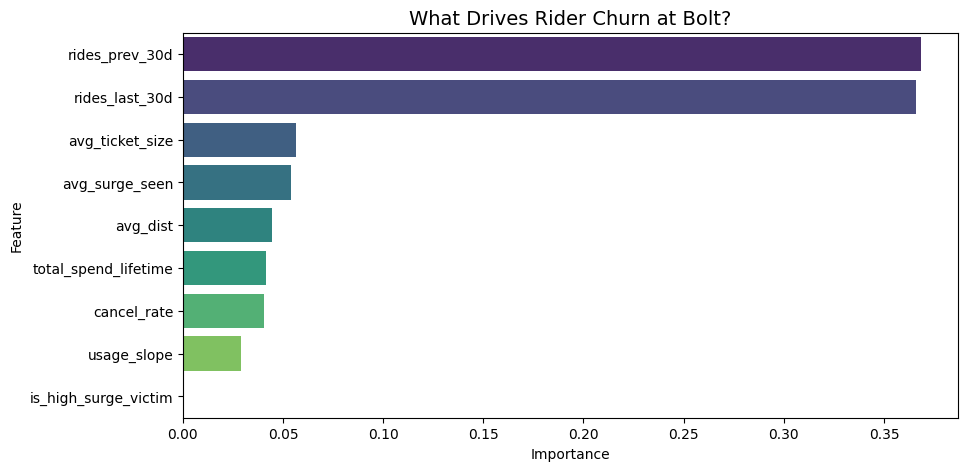


We found 76 High-Value VIPs about to leave.
Strategy: Auto-inject a 'No Surge Pass' for next 3 rides.
          total_spend_lifetime  usage_slope  churn_prob
rider_id                                               
1074                     43.92          0.0    0.893603
5302                     74.55         -1.0    0.837225
1695                     40.99          0.0    0.851435
2586                     87.21         -1.0    0.840578
3842                    106.17          1.0    0.792396


In [12]:
print("\n--- 5. BUSINESS INSIGHTS ---")

# Feature Importance Plot
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=importance, palette='viridis', legend=False)
plt.title('What Drives Rider Churn at Bolt?', fontsize=14)
plt.show()

# --- ACTIONABLE LIST: AT-RISK VIPs ---
# Join predictions back to the test set
results = X_test.copy()
results['churn_prob'] = y_prob

# Logic: High Spend (Top 20%) AND High Churn Risk (> 75%)
high_value_thresh = results['total_spend_lifetime'].quantile(0.80)
at_risk_vips = results[
    (results['total_spend_lifetime'] > high_value_thresh) &
    (results['churn_prob'] > 0.75)
]

print(f"\nWe found {len(at_risk_vips)} High-Value VIPs about to leave.")
print("Strategy: Auto-inject a 'No Surge Pass' for next 3 rides.")
print(at_risk_vips[['total_spend_lifetime', 'usage_slope', 'churn_prob']].head())